In [1]:
from __future__ import division

import pandas as pd
from exosyspop.populations import BinaryPopulation
from exosyspop.populations import TRILEGAL_BGBinaryPopulation
from exosyspop.populations import KeplerBinaryPopulation, PoissonPlanetPopulation
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import PopulationMixture

targets = pd.read_hdf('targets.h5')
bgstars = pd.read_hdf('bgstars.h5')

# Sanitize dtypes of targets DataFrame
for c in targets.columns:
    if targets[c].dtype == object:
        targets.loc[:,c] = targets.loc[:,c].astype(str)


import logging
rootLogger = logging.getLogger()

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [1]:
pop = KeplerPowerLawBinaryPopulation.load('plaw_pop')
pop.set_params(period_min=20, period_max=1200, beta=-0.95, fB=0.14)
catalog = pop.observe(new=True, regr_trap=True)

NameError: name 'KeplerPowerLawBinaryPopulation' is not defined

In [3]:
from exosyspop.survey import DetectionThreshold, DetectionRamp

eff = DetectionRamp(6,16)

In [24]:
import sys
sys.path.append('..')

from simpleabc.simple_abc import Model, basic_abc, pmc_abc
from scipy.stats import gaussian_kde, entropy, anderson_ksamp, uniform
import numpy as np

class PopulationModel(Model):
    """
    Test model for stellar binary population where parameters are fB, beta
    """
    def __init__(self, poplist, eff=None):
        self.poplist = poplist     
        self.eff = eff
        self.period_min = poplist.params['period_min']
        self.period_max = poplist.params['period_max']
        
        self.distance_norms = None
        
    bounds = [(0,1), (-1.5,0), (0,5),(0,5)]
    prior = [uniform(0,1), uniform(-1.5, 1.5), uniform(0,5), uniform(0,5)]
        
    def draw_theta(self):
        """ Draw parameters from prior
        """
        return [p.rvs() for p in self.prior]
        
    def generate_data(self, theta):
        """Generates synthetic catalog
        """
        fB, beta, beta_a, beta_b = theta
        self.poplist.set_params(fB=fB, beta=beta, beta_a=beta_a, beta_b=beta_b)
        try:
            return self.poplist.observe(new=True, 
                                        regr_trap=True).observe(self.eff)
        except:
            print('Error!  theta={}'.format(theta))
            
    def summary_stats(self, data):
        """Computes summary statistics from data
        """
        if data is None:
            return [np.nan]*3
        
        N = len(data)
        
        try:
            Pmin, Pmax = np.log(self.period_min), np.log(self.period_max)
            Pgrid = np.linspace(Pmin, Pmax, 1000)
            if N > 1:
                k = gaussian_kde(np.log(data.period.values))
                p = k(Pgrid)
            else:
                p = np.ones(len(Pgrid))*1./(Pmax - Pmin)
        except ValueError:
            print(data.period.values)
            raise
        
        phase_sec = data.phase_sec.dropna().values
        
        return p, N, phase_sec
        
    def d_period(self, summary_stats, summary_stats_synth):
        p1, _, _ = summary_stats
        p2, _, _ = summary_stats_synth
        try:
            len(p1)
            len(p2)
        except:
            return np.inf
        kl_period = entropy(p1, p2)
        return kl_period
    
    def Ndist(self, N1, N2):
        if N1==0. or N2==0.:
            dist = 1
        else:
            dist = max(1 - 1.*N1/N2, 1-1*N2/N1)
        return dist
            
    def d_N(self, summary_stats, summary_stats_synth):
        _, N1, _ = summary_stats
        _, N2, _ = summary_stats_synth
        return self.Ndist(N1, N2) 
        
    def d_fsec(self, summary_stats, summary_stats_synth):
        _, N1, phase_sec1 = summary_stats
        _, N2, phase_sec2 = summary_stats_synth
        
        f_sec1 = len(phase_sec1)/float(N1)
        f_sec2 = len(phase_sec2)/float(N2)
        
        return np.absolute(f_sec1 - f_sec2)

    def d_phase(self, summary_stats, summary_stats_synth, nbins=11):
        _, _, phase_sec1 = summary_stats
        _, _, phase_sec2 = summary_stats_synth

        try:
            len(phase_sec2)
        except:
            return np.inf
        
        k1 = gaussian_kde(phase_sec1)
        k2 = gaussian_kde(phase_sec2)

        phs = np.linspace(0,1,100)
        pdf1 = k1(phs)
        pdf2 = k2(phs)
        
        return entropy(pdf1, pdf2)
    
    distance_functions = ('d_period', 'd_N', 'd_fsec', 'd_phase')

    def null_distance_test(self, theta_0, N=100):
        data1 = [self.generate_data(theta_0) for i in range(N)]
        data2 = [self.generate_data(theta_0) for i in range(N)]
        
        ds = []
        for dfn in self.distance_functions:
            fn = getattr(self, dfn)
            ds.append([fn(self.summary_stats(data1[i]),
                         self.summary_stats(data2[i])) for i in range(N)])
        
        self._null_stds = np.array([np.std(d) for d in ds])
        self.distance_norms = self._null_stds / self._null_stds[0]
        
    def distance_function(self, summary_stats, summary_stats_synth):
        """Computes distance
        """
        ds = []
        for dfn in self.distance_functions:
            fn = getattr(self, dfn)
            ds.append(fn(summary_stats, summary_stats_synth))
        
        return np.sum([d / self.distance_norms[i] for i,d in enumerate(ds)])
            
        #return d1 + d2 * (0.015/0.072)  #renormalized based on null test
        #return (d1 + d2 + d3 + d4)/4.
        

In [25]:
model = PopulationModel(PopulationMixture([pop]))
theta_0 = 0.14, -0.95, 0.8, 2.0
data = model.generate_data(theta_0)
model.set_data(data)

In [26]:
model.null_distance_test(theta_0, N=100)

In [27]:
model.distance_norms

array([ 1.        ,  3.14920833,  1.97371597,  1.99408711])

In [8]:
posterior = basic_abc(model, data, min_samples=100, epsilon=0.4, verbose=True)

10 samples accepted (10.0%).
24 samples accepted (12.0%).
35 samples accepted (11.7%).
41 samples accepted (10.2%).
53 samples accepted (10.6%).
67 samples accepted (11.2%).
Error!  fB=0.000101185769932, beta=-0.810974815254
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 245, in basic_abc
    synthetic_summary_stats)
  File "<ipython-input-4-aa75c292b951>", line 127, in distance_function
    ds.append(fn(summary_stats, summary_stats_synth))
  File "<ipython-input-4-aa75c292b951>", line 66, in d_period
    kl_period = entropy(p1, p2)
  File "/u/tdm/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py", line 2498, in entropy
    if len(qk) != len(pk):
TypeError: len() of unsized object

81 samples accepted (11.6%).
92 samples accepted (11.5%).
Error!  fB=0.00359319682528, beta=-0.332810440468
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 245, in basic_abc
    sy

In [ ]:
pmc_posterior = pmc_abc(model, data, epsilon_0=0.3, min_samples=200, steps=20, verbose=True)

Starting step 0, epsilon=0.3
Error!  theta=[0.0027675345111886074, -0.04173890078481546, 0.08395916653485547, 4.353831790534039]
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 245, in basic_abc
    synthetic_summary_stats)
  File "<ipython-input-24-d7325be88d5b>", line 132, in distance_function
    ds.append(fn(summary_stats, summary_stats_synth))
  File "<ipython-input-24-d7325be88d5b>", line 91, in d_fsec
    f_sec2 = len(phase_sec2)/float(N2)
TypeError: object of type 'float' has no len()

10 samples accepted (10.0%).
15 samples accepted (7.5%).
22 samples accepted (7.3%).
31 samples accepted (7.8%).
35 samples accepted (7.0%).
44 samples accepted (7.3%).
Error!  theta=[0.005375463660796331, -0.5558756286084341, 2.1497139562112384, 3.8248304953532153]
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 245, in basic_abc
    synthetic_summary_stats)
  File "<ipython-input-24-d7325be88

In [18]:
pmc_posterior['epsilon'][-1]

0.099976192000031383

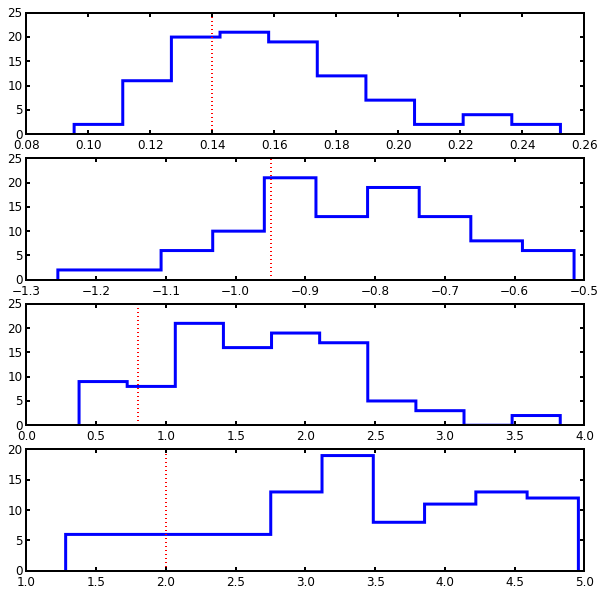

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(10,10))

for i,ax in enumerate(axes):
    ax.hist(pmc_posterior[-1][0][i,:], histtype='step', lw=3)
    ax.axvline(theta_0[i], color='r', ls=':')

In [20]:
pmc_posterior[-1][0].shape

(4, 100)

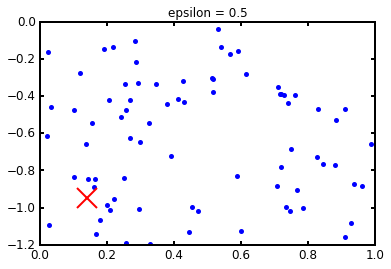

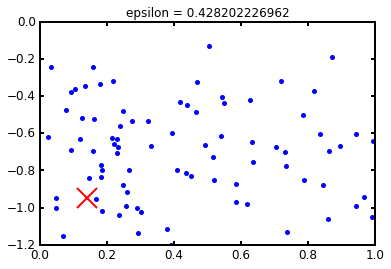

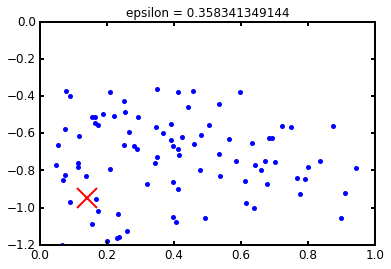

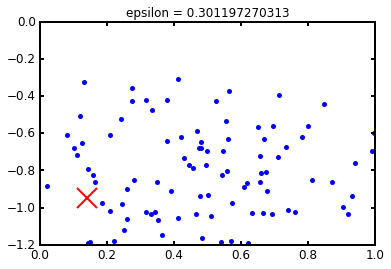

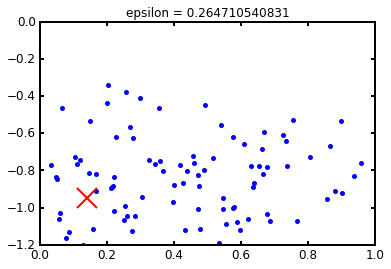

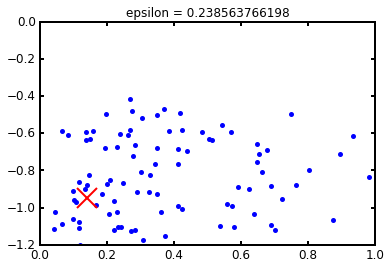

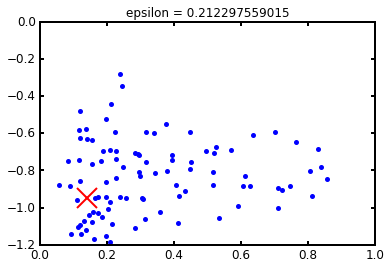

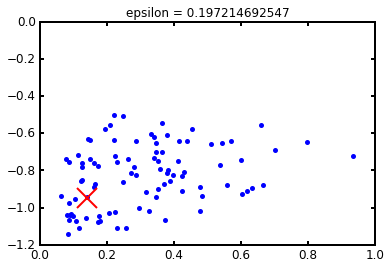

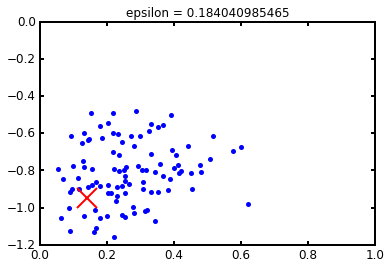

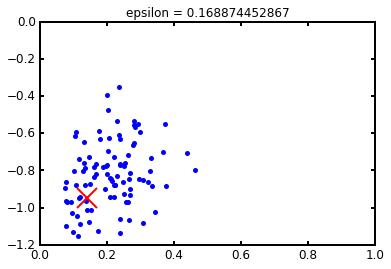

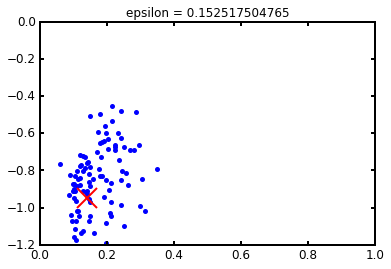

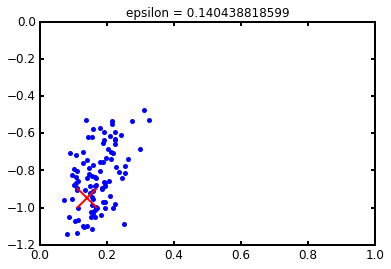

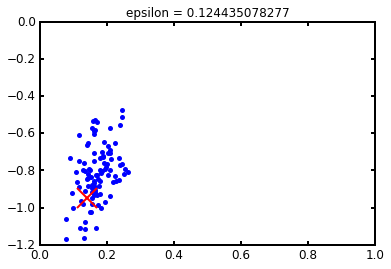

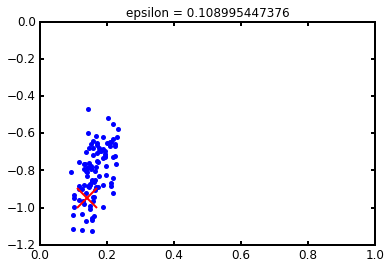

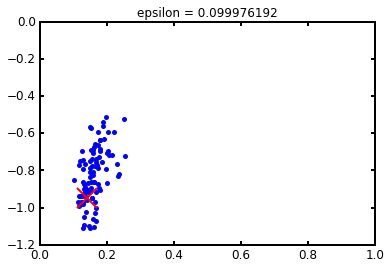

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(pmc_posterior.shape[0]):
    plt.figure()
    plt.plot(pmc_posterior[i][0][0,:], pmc_posterior[i][0][1,:], '.');
    plt.title('epsilon = {}'.format(pmc_posterior[i]['epsilon']))
    plt.plot(0.14, -0.95, 'rx', ms=20)
    plt.xlim(0,1)
    plt.ylim(-1.2, 0)